# House Prices: Linear Regression from Scratch

Implemented using several sources:

- [Mathematics for Machine Learning](https://mml-book.github.io)
- [Data Science Machine Learning](https://people.smp.uq.edu.au/DirkKroese/DSML)


In [1]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder

# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn import model_selection, metrics


# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

pd.options.display.max_columns = 100

from itertools import cycle

plt.style.use("fivethirtyeight")  # ggplot, fivethirtyeight
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

In [3]:
class Config:
    path = "../input/house-prices-advanced-regression-techniques"
    gpu = False
    optimize = False
    model_type = "xgb"  # (xgb, cat, lgbm, keras)
    model_name = "xgb1"
    debug = False
    competition = "Housing Prices"
    seed = 42
    N_ESTIMATORS = 100  # 5000
    N_FOLDS = 5
    EPOCHS = 10

In [4]:
TARGET = "SalePrice"

In [5]:
def create_submission(model_name, target, preds):
    sample_submission[target] = preds
    sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    return sample_submission

In [6]:
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [7]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [8]:
train, test, sample_submission = read_data(Config.path)

train data: Rows=1460, Columns=81
test data : Rows=1459, Columns=80


In [9]:
train.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
742,743,20,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,2000,2001,Gable,CompShg,VinylSd,VinylSd,BrkFace,108.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1349,1349,GasA,Ex,Y,SBrkr,1349,0,0,1349,0,0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,2000.0,Unf,2,539,TA,TA,Y,120,55,0,0,0,0,NaN,GdPrv,NaN,0,12,2007,WD,Normal,179000
446,447,20,RL,137.0,16492,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,PosA,Norm,1Fam,1Story,6,6,1966,2002,Gable,CompShg,BrkFace,Plywood,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,247,Rec,713,557,1517,GasA,Ex,Y,SBrkr,1888,0,0,1888,0,0,2,1,2,1,Gd,6,Mod,1,Gd,Attchd,1966.0,Fin,2,578,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,190000
810,811,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1974,1999,Hip,CompShg,HdBoard,HdBoard,BrkFace,99.0,TA,TA,CBlock,TA,TA,No,ALQ,663,LwQ,377,0,1040,GasA,Fa,Y,SBrkr,1309,0,0,1309,1,0,1,1,3,1,Gd,5,Typ,1,Fa,Attchd,1974.0,RFn,2,484,TA,TA,Y,265,0,0,0,0,648,Fa,GdPrv,NaN,0,1,2006,WD,Normal,181000
651,652,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Artery,Norm,1Fam,2Story,4,5,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,Unf,0,Unf,0,755,755,GasA,TA,Y,SBrkr,755,755,0,1510,1,0,1,0,4,1,TA,7,Typ,1,Gd,Detchd,1940.0,Unf,1,296,Fa,Po,P,120,0,0,0,0,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal,108000
532,533,20,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1955,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Ex,Y,SBrkr,827,0,0,827,0,0,1,0,2,1,TA,5,Mod,1,Po,Detchd,1967.0,Unf,1,392,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,107500


In [10]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [11]:
print("=" * 5, "Missing Training Data", "=" * 5)
print(train.isnull().sum())
print("=" * 5, "Missing Test Data", "=" * 5)
print(test.isnull().sum())

===== Missing Training Data =====
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64
===== Missing Test Data =====
Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64


In [12]:
numerical_features = ["LotArea", "GrLivArea"]
# numerical_features = ["LotArea"]

In [13]:
FEATURES = numerical_features

FEATURES = [
    "MSSubClass",
    "MSZoning",
    "LotFrontage",
    "LotArea",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinSF1",
    "BsmtFinType2",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MiscVal",
    "MoSold",
    "YrSold",
    "SaleType",
    "SaleCondition",
]

In [14]:
encode = [
    "MSSubClass",
    "MSZoning",
    "LotFrontage",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",
    "OverallCond",
    #     "YearBuilt",
    #     "YearRemodAdd",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    #     "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinSF1",
    "BsmtFinType2",
    "BsmtFinSF2",
    "BsmtUnfSF",
    #     "TotalBsmtSF",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    #     "1stFlrSF",
    #     "2ndFlrSF",
    #     "LowQualFinSF",
    #     "GrLivArea",
    #     "BsmtFullBath",
    #     "BsmtHalfBath",
    #     "FullBath",
    #     "HalfBath",
    #     "BedroomAbvGr",
    #     "KitchenAbvGr",
    "KitchenQual",
    #     "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MiscVal",
    "MoSold",
    "YrSold",
    "SaleType",
    "SaleCondition",
]

train, test = label_encoder(train, test, encode)

In [15]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

## Forward Selection and Backward Elimination

In [16]:
import statsmodels.api as sm

from statsmodels.formula.api import ols

selected_features = []

remaining_features = [
    "MSSubClass",
    "MSZoning",
    "LotFrontage",
    "LotArea",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinSF1",
    "BsmtFinType2",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MiscVal",
    "MoSold",
    "YrSold",
    "SaleType",
    "SaleCondition",
]


remaining_features = [
    "MSSubClass",
    "MSZoning",
    "LotFrontage",
    "LotArea",
    "Street",
    "Alley",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFinSF1",
    "BsmtFinType2",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "Heating",
    "HeatingQC",
    "CentralAir",
    "Electrical",
    #     "1stFlrSF",
    #     "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageType",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "PavedDrive",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    #     "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscFeature",
    "MiscVal",
    "MoSold",
    "YrSold",
    "SaleType",
    "SaleCondition",
]

FEATURES = remaining_features

formula = ""

while remaining_features and len(selected_features) < 2:
    PF = []
    n_features = len(selected_features)
    print(f"\n === Selected features: {selected_features} ===")
    print(f"\nn={n_features}, Best formula: {formula}")
    # list of (P value, feature)

    for feature in remaining_features:
        #         print(f"Checking feature: {feature}")
        temp = selected_features + [feature]

        # temporary list of features

        formula = "SalePrice~" + "+".join(temp)
        fit = ols(formula, data=train).fit()

        pval = fit.pvalues[-1]
        #         print(f"{formula}, {pval}")

        if pval < 0.05:
            print(f"Keep: {feature}, {formula}, p={pval}")
            PF.append((pval, feature))
    #         else:
    #             print(f"Skip: {feature}, p={pval}")
    if PF:

        # if not empty
        #         print(f"Unsorted={PF}\n\n")
        PF.sort(reverse=True)
        print(f"Reverse sorted={PF}")
        (best_pval, best_f) = PF.pop()

        remaining_features.remove(
            best_f
        )  # Remove the best then continue trying the others

        print(
            "\n->Best feature {} with best P-value = {:.2E}".format(best_f, best_pval)
        )

        selected_features.append(best_f)
        print(f"Selected Features: {selected_features}")
        print(10 * "=", "\n\n")
    else:
        break  # When no feature with P-value < 0.05 remains, we're done


 === Selected features: [] ===

n=0, Best formula: 
Keep: MSSubClass, SalePrice~MSSubClass, p=0.03630525537158652
Keep: MSZoning, SalePrice~MSZoning, p=1.4013002757706294e-10
Keep: LotArea, SalePrice~LotArea, p=1.1231391549186041e-24
Keep: Alley, SalePrice~Alley, p=8.043097929703818e-08
Keep: LotShape, SalePrice~LotShape, p=3.3207118181991816e-23
Keep: LotConfig, SalePrice~LotConfig, p=0.009997321823666323
Keep: Neighborhood, SalePrice~Neighborhood, p=3.90673280425688e-16
Keep: Condition1, SalePrice~Condition1, p=0.0004879176783950963
Keep: BldgType, SalePrice~BldgType, p=0.001061792696353839
Keep: HouseStyle, SalePrice~HouseStyle, p=4.064282849445137e-12
Keep: OverallQual, SalePrice~OverallQual, p=2.291032330589944e-99
Keep: OverallCond, SalePrice~OverallCond, p=0.002912351267915664
Keep: YearBuilt, SalePrice~YearBuilt, p=2.990229099013344e-103
Keep: YearRemodAdd, SalePrice~YearRemodAdd, p=3.1649482419160998e-96
Keep: RoofStyle, SalePrice~RoofStyle, p=8.060304484029286e-18
Keep: Roof

In [17]:
best_f

'BsmtQual'

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1168, 79), (1168,), (292, 79), (292,))

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Linear Regression Using OLS</h1>
</div>

In [19]:
import statsmodels.api as sm

from statsmodels.formula.api import ols

In [20]:
myData = pd.DataFrame(
    {
        "y": [10, 9, 4, 2, 4, 9],
        "x1": [7.4, 1.2, 3.1, 4.8, 2.8, 6.5],
        "x2": [1, 1, 2, 2, 3, 3],
    }
)

mod = ols("y~x1+x2", data=myData)

mod_matrix = pd.DataFrame(mod.exog, columns=mod.exog_names)

print(mod_matrix)

   Intercept   x1   x2
0        1.0  7.4  1.0
1        1.0  1.2  1.0
2        1.0  3.1  2.0
3        1.0  4.8  2.0
4        1.0  2.8  3.0
5        1.0  6.5  3.0


Text(0, 0.5, ' SalePrice')

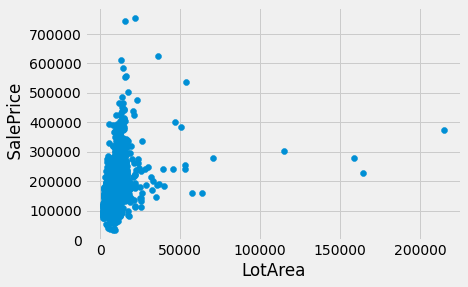

In [21]:
plt.scatter(train.LotArea, train.SalePrice)

plt.xlabel("LotArea")
plt.ylabel(" SalePrice")

In [22]:
model = ols("SalePrice~LotArea", data=train)

fit = model.fit()

b0, b1 = fit.params

print(fit.params)

# fit the

Intercept    158836.151897
LotArea           2.099972
dtype: float64


In [23]:
model = ols("SalePrice~LotArea+GrLivArea", data=train)
model = ols(
    "SalePrice~GrLivArea+BsmtQual+YearBuilt+KitchenQual+TotalBsmtSF+OverallCond+GarageCars+Fireplaces+ExterQual+BldgType+SaleCondition",
    data=train,
)
FEATURES = [
    "GrLivArea",
    "BsmtQual",
    "YearBuilt",
    "KitchenQual",
    "TotalBsmtSF",
    "OverallCond",
    "GarageCars",
    "Fireplaces",
    "ExterQual",
    "BldgType",
    "BsmtFullBath",
]

model = ols(
    "SalePrice~GrLivArea+BsmtQual+YearBuilt+KitchenQual+TotalBsmtSF+OverallCond+GarageCars+Fireplaces+ExterQual+BldgType+SaleCondition",
    data=train,
)

fit = model.fit()

# b0, b1, b2 = fit.params

print(fit.params)

Intercept       -899355.767453
GrLivArea            53.452929
BsmtQual         -12524.739341
YearBuilt           500.833214
KitchenQual      -11798.210657
TotalBsmtSF          23.743278
OverallCond        8373.017025
GarageCars        14625.965223
Fireplaces        12164.350118
ExterQual        -13303.023698
BldgType          -5007.726599
SaleCondition      2124.690887
dtype: float64


In [24]:
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     536.7
Date:                Tue, 28 Jun 2022   Prob (F-statistic):               0.00
Time:                        12:43:04   Log-Likelihood:                -17358.
No. Observations:                1460   AIC:                         3.474e+04
Df Residuals:                    1448   BIC:                         3.480e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.994e+05   8.84e+04    -10.168

In [25]:
FEATURES = [
    "GrLivArea",
    "BsmtQual",
    "YearBuilt",
    "KitchenQual",
    "TotalBsmtSF",
    "OverallCond",
    "GarageCars",
    "Fireplaces",
    "ExterQual",
    "BldgType",
    "BsmtFullBath",
    "SaleCondition",
]

In [26]:
X_valid.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
892,4,3,80,8414,1,2,3,3,0,4,0,19,2,2,0,2,6,7,1963,2003,3,1,6,6,2,0.0,3,4,1,3,3,3,2,473,5,0,407,1059,1,4,1,4,1068,0,0,1068,0,1,1,0,3,1,3,6,6,0,5,1,49,1,1,44,4,4,2,74,0,0,0,0,0,3,2,4,0,4,0,8,4
1105,9,3,108,12256,1,2,0,3,0,0,0,15,2,2,0,5,8,4,1994,1995,1,1,6,6,1,362.0,2,4,2,0,3,0,2,13,5,0,438,1463,1,0,1,4,1500,1122,0,2622,1,0,2,1,3,1,2,9,6,2,4,1,80,1,2,337,4,4,2,70,130,0,0,0,0,3,4,4,0,6,4,8,4
413,5,4,66,8960,1,0,3,3,0,4,0,17,0,2,0,2,5,5,1927,1950,1,1,14,15,2,0.0,3,4,1,3,3,3,5,0,5,0,4,1008,1,2,1,0,1028,0,0,1028,0,0,1,0,2,1,3,5,6,1,2,5,15,2,2,93,4,4,2,0,0,14,0,0,0,3,4,4,0,5,4,8,4
522,8,4,60,5000,1,2,3,3,0,0,0,3,1,2,0,0,6,6,1947,1950,1,1,5,5,2,0.0,3,2,1,3,3,3,0,298,5,0,550,1004,1,0,1,4,1004,660,0,1664,0,0,2,0,3,1,3,7,6,2,2,5,36,2,2,129,4,4,2,0,100,91,0,0,0,3,4,4,0,1,0,8,4
1036,4,3,99,12898,1,2,0,1,0,4,0,23,2,2,0,2,9,4,2007,2008,3,1,12,13,3,70.0,2,4,2,0,3,1,2,11,5,0,544,1620,1,0,1,4,1620,0,0,1620,1,0,2,0,2,1,0,6,6,1,0,1,94,0,3,431,4,4,2,100,0,0,0,0,0,3,4,4,0,11,3,8,4


In [27]:
FEATURES

['GrLivArea',
 'BsmtQual',
 'YearBuilt',
 'KitchenQual',
 'TotalBsmtSF',
 'OverallCond',
 'GarageCars',
 'Fireplaces',
 'ExterQual',
 'BldgType',
 'BsmtFullBath',
 'SaleCondition']

In [28]:
X_valid[FEATURES]

,GrLivArea,BsmtQual,YearBuilt,KitchenQual,TotalBsmtSF,OverallCond,GarageCars,Fireplaces,ExterQual,BldgType,BsmtFullBath,SaleCondition
892,1068,3,1963,3,1059,7,1,0,3,0,0,4
1105,2622,0,1994,2,1463,4,2,2,2,0,1,4
413,1028,3,1927,3,1008,5,2,1,3,0,0,4
522,1664,3,1947,3,1004,6,2,2,3,0,0,4
1036,1620,0,2007,0,1620,4,3,1,2,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
479,1131,1,1937,3,907,6,2,0,3,0,0,2
1361,1530,0,2005,2,1530,4,2,1,2,0,1,4
802,1456,2,2005,2,728,4,2,1,2,0,1,4
651,1510,3,1940,3,755,4,1,1,3,0,1,4


In [29]:
preds = fit.get_prediction(X_valid[FEATURES])

# preds = fit.get_prediction(X_valid[FEATURES])


X_valid[FEATURES].shape, preds.predicted_mean.shape

((292, 12), (292,))

In [30]:
preds.predicted_mean[:10]

array([134869.61736353, 319564.64934109, 123534.87863679, 187989.99966759,
       302301.37748448,  66900.70098055, 236440.83649506, 157451.04709501,
        70906.7611519 , 134092.51999316])

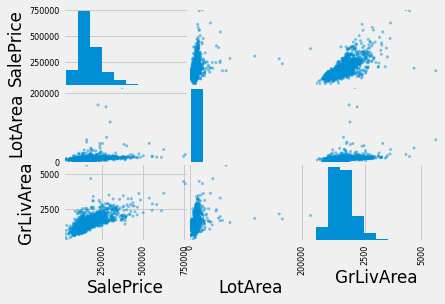

In [31]:
axes = pd.plotting.scatter_matrix(
    # model = ols("SalePrice~LotArea+GrLivArea", data=train)
    train[["SalePrice", "LotArea", "GrLivArea"]]
)
plt.show()

In [32]:
X_test[FEATURES].isnull()

,GrLivArea,BsmtQual,YearBuilt,KitchenQual,TotalBsmtSF,OverallCond,GarageCars,Fireplaces,ExterQual,BldgType,BsmtFullBath,SaleCondition
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1454,False,False,False,False,False,False,False,False,False,False,False,False
1455,False,False,False,False,False,False,False,False,False,False,False,False
1456,False,False,False,False,False,False,False,False,False,False,False,False
1457,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
print(X_test[FEATURES].isnull().sum())

GrLivArea        0
BsmtQual         0
YearBuilt        0
KitchenQual      0
TotalBsmtSF      1
OverallCond      0
GarageCars       0
Fireplaces       0
ExterQual        0
BldgType         0
BsmtFullBath     2
SaleCondition    0
dtype: int64


In [34]:
X_test["TotalBsmtSF"] = X_test["TotalBsmtSF"].fillna(0)
X_test["BsmtFullBath"] = X_test["BsmtFullBath"].fillna(0)

In [35]:
%%time
preds = fit.get_prediction(X_test[FEATURES])

CPU times: user 25.3 ms, sys: 6.4 ms, total: 31.7 ms
Wall time: 22.6 ms


In [36]:
X_test.shape, preds.predicted_mean.shape

((1459, 79), (1459,))

In [37]:
preds.summary_frame(alpha=0.05).unstack()

mean          0       103725.452967
              1       147779.527318
              2       192970.673917
              3       199734.185696
              4       173075.047308
                          ...      
obs_ci_upper  1454    159248.652521
              1455    143771.718802
              1456    225418.616386
              1457    183221.175257
              1458    296655.641432
Length: 8754, dtype: float64

In [38]:
table = sm.stats.anova_lm(fit)

print(table)

                   df        sum_sq       mean_sq            F         PR(>F)
GrLivArea         1.0  4.623740e+12  4.623740e+12  3691.902656   0.000000e+00
BsmtQual          1.0  1.428353e+12  1.428353e+12  1140.492371  7.072444e-185
YearBuilt         1.0  4.545874e+11  4.545874e+11   362.972890   2.175207e-72
KitchenQual       1.0  2.653808e+11  2.653808e+11   211.897710   6.667976e-45
TotalBsmtSF       1.0  1.734035e+11  1.734035e+11   138.456912   1.362458e-30
OverallCond       1.0  1.411926e+11  1.411926e+11   112.737585   2.060370e-25
GarageCars        1.0  1.276965e+11  1.276965e+11   101.961406   3.253775e-23
Fireplaces        1.0  7.078481e+10  7.078481e+10    56.519314   9.709018e-14
ExterQual         1.0  5.340664e+10  5.340664e+10    42.643423   9.066450e-11
BldgType          1.0  4.847949e+10  4.847949e+10    38.709256   6.425518e-10
SaleCondition     1.0  7.410616e+09  7.410616e+09     5.917130   1.511482e-02
Residual       1448.0  1.813476e+12  1.252400e+09          NaN  

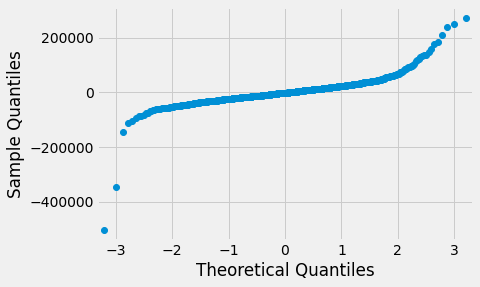

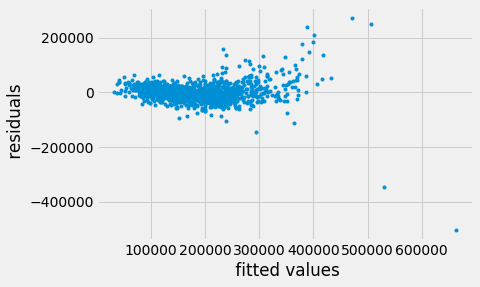

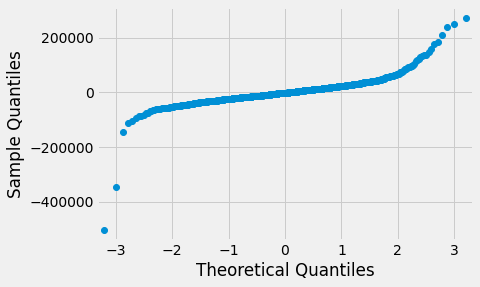

In [39]:
plt.plot(fit.fittedvalues, fit.resid, ".")

plt.xlabel(" fitted values")

plt.ylabel(" residuals")

sm.qqplot(fit.resid)

In [40]:
preds.predicted_mean.shape

(1459,)

In [41]:
create_submission("lr", TARGET, preds.predicted_mean)

,Id,SalePrice
0,1461,103725.452967
1,1462,147779.527318
2,1463,192970.673917
3,1464,199734.185696
4,1465,173075.047308
...,...,...
1454,2915,89455.856613
1455,2916,73829.297638
1456,2917,155541.950214
1457,2918,113444.854755


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Linear Regression Using MLE</h1>
</div>

1. Calculate $\theta$
2. Use $\theta$ for inference

In [42]:
import scipy.linalg


def max_lik_estimate(X, y):

    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)

    #     N, D = X.shape
    theta_ml = np.linalg.solve(X.T @ X, X.T @ y)  ## <-- SOLUTION
    return theta_ml

In [43]:
## EDIT THIS FUNCTION
# def max_lik_estimate_aug(X_aug, y):
def max_lik_estimate_aug(X, y):

    N, D = X.shape
    X_aug = np.hstack(
        [np.ones((N, 1)), X]
    )  # augmented training inputs of size N x (D+1)
    #     theta_aug = np.zeros((D+1, 1)) # new theta vector of size (D+1) x 1

    theta_aug_ml = max_lik_estimate(X_aug, y)  ## <-- SOLUTION

    return theta_aug_ml

In [44]:
def predict_with_estimate(Xtest, theta):

    # Xtest: K x D matrix of test inputs
    # theta: D x 1 vector of parameters
    # returns: prediction of f(Xtest); K x 1 vector

    prediction = Xtest @ theta  ## <-- SOLUTION

    return prediction

In [45]:
def RMSE(y, ypred):
    rmse = np.sqrt(np.mean((y - ypred) ** 2))
    return rmse

In [46]:
# FEATURES = ["LotArea"]
FEATURES = ["LotArea", "GrLivArea"]

In [47]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [48]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((1168, 2), (1168,), (292, 2), (292,))

In [49]:
# get maximum likelihood estimate
theta_ml = max_lik_estimate(X_train, y_train)

Text(0, 0.5, '$y$')

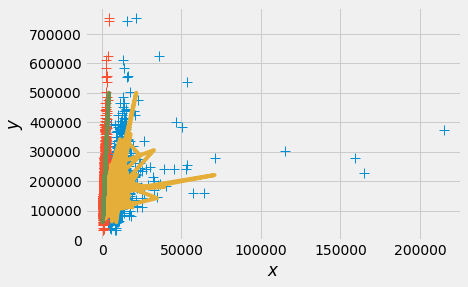

In [50]:
# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_valid, theta_ml)

# plot
plt.figure()
plt.plot(X, y, "+", markersize=10)
plt.plot(X_valid, ml_prediction)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [51]:
ml_prediction.shape

(292,)

In [52]:
ml_prediction[:10]

892     125790.551812
1105    303111.043434
413     121664.787974
522     190474.566365
1036    190897.811099
614      71841.425749
218     230325.638002
1160    165240.831328
649      72143.986292
887     167803.285692
dtype: float64

In [53]:
rmse = RMSE(ml_prediction, y_valid)
rmse

57308.998260162654

In [54]:
ml_prediction = predict_with_estimate(X_test, theta_ml)

In [55]:
create_submission("mle", TARGET, ml_prediction)

,Id,SalePrice
0,1461,108634.627036
1,1462,159112.967992
2,1463,192543.312431
3,1464,187113.671839
4,1465,147306.809836
...,...,...
1454,2915,124084.283457
1455,2916,124055.727181
1456,2917,151206.286667
1457,2918,116151.093290


<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Augmented X</h1>
</div>

In [56]:
theta_ml_aug = max_lik_estimate_aug(X_train, y_train)

In [57]:
# X_valid_aug = np.hstack(
#     [np.ones((N, 1)), X]
#     )  # augmented training inputs of size N x (D+1)

X_valid_aug = np.hstack(
    [np.ones((X_valid.shape[0], 1)), X_valid]
)  # 100 x (D + 1) vector of test inputs

Text(0, 0.5, '$y$')

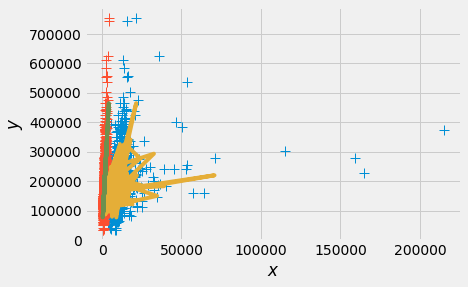

In [58]:
# predict the function values at the test points using the maximum likelihood estimator
ml_prediction = predict_with_estimate(X_valid_aug, theta_ml_aug)

# plot
plt.figure()
plt.plot(X, y, "+", markersize=10)
plt.plot(X_valid, ml_prediction)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [59]:
ml_prediction.shape

(292,)

In [60]:
rmse = RMSE(ml_prediction, y_valid)
rmse

58219.6806903323

In [61]:
X_test_aug = np.hstack(
    [np.ones((X_test.shape[0], 1)), X_test]
)  # 100 x (D + 1) vector of test inputs

In [62]:
ml_prediction = predict_with_estimate(X_test_aug, theta_ml_aug)

In [63]:
create_submission("mle_aug", TARGET, ml_prediction)

,Id,SalePrice
0,1461,119473.185572
1,1462,164026.459474
2,1463,193473.453200
3,1464,188584.396887
4,1465,153371.710532
...,...,...
1454,2915,132824.782696
1455,2916,132798.479989
1456,2917,157214.545580
1457,2918,126064.676375


 <div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Polynomial Features</h1>
</div>